# Clustering algorithms in word embedding models

## word2vec

In [1]:
from gensim.models import Word2Vec

# load pre-trained model
model = Word2Vec.load("../word2vec/models/rus/sentirueval_old/300features_20minwords_10context_full")
# For binary models
# model = Word2Vec.load_word2vec_format('../models/***.bin', binary=True)

print("Model: %s" % model)

# Word vectors
word_vectors = model.syn0
# List of words
words = model.index2word

print('# words in model: %s' % len(word_vectors))
print()

num_2_show = 10
print("First %d words:" % num_2_show)
for ix, word in enumerate(words[:num_2_show]):
    print(word)

C:\Program Files\Anaconda3\lib\site-packages\gensim\utils.py:855: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


Model: Word2Vec(vocab=1619, size=300, alpha=0.025)
# words in model: 1619

First 10 words:
нормальный
хабаровский
система
48
результат
свалка
рассказывать
екатеринбург
устраивать
баланс


## Compute Cosine Similarity

Use Cosine Similarity measure to calculate the similarity between different documents. Source: http://blog.christianperone.com/2013/09/machine-learning-cosine-similarity-for-vector-space-models-part-iii/

In [2]:
import scipy

def cos_cdist(matrix, vector):
    """
    Compute the cosine distances between each row of matrix and vector.
    """
    v = vector.reshape(1, -1)
    return scipy.spatial.distance.cdist(matrix, v, 'cosine').reshape(-1)

## Apply k-means clustering (KM) for word vectors

### Set number of clusters

In [3]:
n_clusters = 30

### Clustering

In [4]:
import sys
from time import time
import numpy as np
import warnings

from sklearn.cluster import KMeans, MiniBatchKMeans


X = word_vectors

print("Shape of input array: ", X.shape)
print()

if 0:
    km = MiniBatchKMeans(n_clusters=n_clusters,
                         init='k-means++',
                         n_init=1,
                         init_size=1000,
                         batch_size=1000,
                         random_state=10)
else:
    km = KMeans(n_clusters=n_clusters,
                init='k-means++',
                max_iter=100,
                n_init=1,
                random_state=10)

print("Clustering algorithm:")
print(km)

t0 = time()
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    km_labels = km.fit_predict(X)
print("Execution time: %0.3fs" % (time() - t0))

Shape of input array:  (1619, 300)

Clustering algorithm:
KMeans(copy_x=True, init='k-means++', max_iter=100, n_clusters=30, n_init=1,
    n_jobs=1, precompute_distances='auto', random_state=10, tol=0.0001,
    verbose=0)
Execution time: 0.697s


### Visualization

Using Principal Component Analysis (PCA) (https://en.wikipedia.org/wiki/Principal_component_analysis) and compute Silhouette Coefficient (SC) (https://en.wikipedia.org/wiki/Silhouette_(clustering)).

Silhouette Coefficient: 0.085



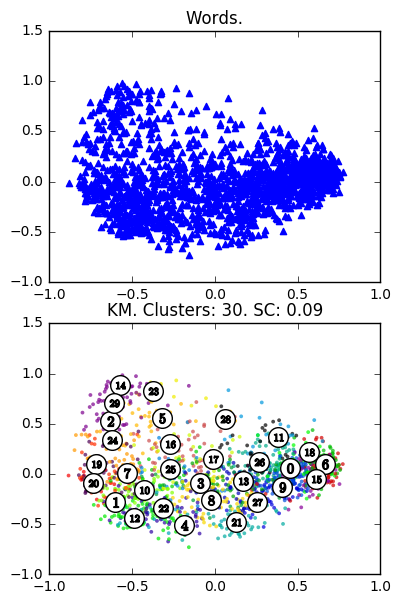

In [5]:
%matplotlib inline

from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import matplotlib.cm as cm


pca = PCA(2)
pca_vectors = pca.fit_transform(word_vectors)

# tsne = TSNE(n_components=2, random_state=0)
# pca_vectors = tsne.fit_transform(word_vectors)

fig, (ax1, ax2) = plt.subplots(2, figsize=(4, 6))
fig.tight_layout()

ax1.scatter(pca_vectors[:, 0],
            pca_vectors[:, 1],
            marker='^',
            color='b')

# For showing on the plot
km_pca = KMeans(n_clusters=n_clusters,
                init='k-means++',
                max_iter=100,
                n_init=1,
                random_state=10)
km_labels_pca = km_pca.fit_predict(pca_vectors)

colors = cm.spectral(km_labels.astype(float) / n_clusters)
ax2.scatter(pca_vectors[:, 0], 
            pca_vectors[:, 1],
            marker='.', s=30, lw=0, alpha=0.7, c=colors)

centers = km_pca.cluster_centers_
ax2.scatter(centers[:, 0],
            centers[:, 1],
            marker='o', c="white", alpha=1, s=200)

for i, c in enumerate(centers):
    ax2.scatter(c[0],
                c[1],
                marker='$%d$' % i, alpha=1, s=50)

sc = metrics.silhouette_score(X, km.labels_, sample_size=1000)
print("Silhouette Coefficient: %0.3f" % sc)
print()

ax1.set_title('Words.')
ax2.set_title('KM. Clusters: {0}. SC: {1:.2f}'.format(n_clusters, sc))

## Calculate semantic word vectors

### Cosine Similarity inside each cluster

In [6]:
words_array = np.asarray(words)

# Words in each cluster
cluster_words = []
cluster_vectors = []
cluster_pca_vectors = []

# Distance for word in each cluster
cluster_cos_sim = []
cluster_cos_sim_sort_asc = []
cluster_cos_sim_sort_des = []

for i in range(n_clusters):
    cluster_words.append(words_array[km_labels == i])
    cluster_vectors.append(word_vectors[km_labels == i])
    cluster_pca_vectors.append(pca_vectors[km_labels == i])
    
    cluster_cos_sim.append(cos_cdist(cluster_vectors[i], km.cluster_centers_[i]))
    cluster_cos_sim_sort_asc.append(cluster_cos_sim[i].argsort())
    cluster_cos_sim_sort_des.append(cluster_cos_sim_sort_asc[i][::-1])

### Semantic vector for each word in model using KM

Set threshold according to the experiment.

In [7]:
# TODO: find this value
CLUSTER_THRESHOLD = 0.5
INVALID_VALUE = 2.0 # MAX value
UNKNOWN_VECTOR = np.empty(n_clusters)
UNKNOWN_VECTOR.fill(INVALID_VALUE)

In [8]:
num_words = len(word_vectors)

# Shape is (num words in model) * (num clusters)
semantic_word_vectors = np.zeros(shape=(num_words,n_clusters))

for ix_cluster, center in enumerate(km.cluster_centers_):
    semantic_word_vectors[:, ix_cluster] = cos_cdist(word_vectors, center)
    ix2discard = semantic_word_vectors[:, ix_cluster] > CLUSTER_THRESHOLD  # threshold values
    semantic_word_vectors[ix2discard, ix_cluster] = INVALID_VALUE

#### Example output (semantic vectors)

In [9]:
print("Semantic word vectors shape: ", semantic_word_vectors.shape)
for ix, vector in enumerate(semantic_word_vectors[:2,:]):
    print("Word: ", words[ix])
    min_ix = np.argmin(vector) # [np.nonzero(vector)]
    print("Cluster: ", min_ix, " Distance: ", vector[min_ix])
    print("Vector: ", vector.shape)
    print(vector)
    print()

Semantic word vectors shape:  (1619, 30)
Word:  нормальный
Cluster:  7  Distance:  0.0913597734124
Vector:  (30,)
[ 0.1111048   2.          2.          0.32143088  2.          0.34228136
  0.20888674  0.09135977  2.          0.40829001  2.          0.4729228
  0.14613654  2.          0.26519109  0.12193955  2.          2.
  0.11231073  2.          0.48941236  2.          0.34453484  2.          2.
  2.          2.          2.          0.10147499  0.41002554]

Word:  хабаровский
Cluster:  25  Distance:  0.071502462719
Vector:  (30,)
[ 2.          0.14834126  0.49313961  2.          0.25552378  0.46354693
  2.          2.          0.24692537  2.          0.20001967  2.          2.
  2.          0.48008124  2.          0.21011409  0.18153274  2.
  0.09984806  0.38780171  2.          0.33076971  0.34268733  0.13976874
  0.07150246  0.25456694  2.          2.          0.28611062]



### Test semantic model on small text

In [10]:
test_texts = [["мтс", "плохо", "работать", "москва"],
              ["сбер", "договор", "воронеж", "криво"]] # ["мегафон", "баланс", "0"]
test_vectors = np.zeros((len(test_texts), n_clusters))

for ix, test_text in enumerate(test_texts):
    num_test_words = 0
    print("Text: ", test_text)
    
    for word in test_text:
        index = np.where(words_array == word)
        if index[0] != 0:
            vector = semantic_word_vectors[index]
            num_test_words += 1
        else:
            continue
#             vector = UNKNOWN_VECTOR
        test_vectors[ix] += vector[0]
        print("Word: ", word, 
              " Cluster: ", np.argmin(vector),
              " Distance: ", vector[0, np.argmin(vector)])
#         print(index)
#         print(vector)
        print()

    if num_test_words != 0:
        test_vectors[ix] = np.divide(test_vectors[ix], num_test_words)

    min_ix = np.argmin(test_vectors[ix])
    print("Cluster: ", min_ix, " Distance: ", test_vectors[ix, min_ix])
    print("Vector: ", test_vectors[ix].shape)
    print(test_vectors[ix])
    print()

print("Cosine similarity: ", scipy.spatial.distance.cosine(test_vectors[0], test_vectors[1]))

Text:  ['мтс', 'плохо', 'работать', 'москва']
Word:  мтс  Cluster:  18  Distance:  0.119971298217

Word:  плохо  Cluster:  15  Distance:  0.0424821749342

Word:  работать  Cluster:  15  Distance:  0.10110350008

Word:  москва  Cluster:  20  Distance:  0.304107979533

Cluster:  18  Distance:  0.219205874705
Vector:  (30,)
[ 0.77854227  2.          2.          0.82846274  2.          0.80862701
  0.33577491  0.65309386  1.60302417  1.18664486  1.61277911  0.79978055
  0.71874386  1.60133666  0.39905511  0.60895726  1.61732185  1.61998963
  0.21920587  2.          1.18069671  2.          0.80985785  2.          2.
  2.          2.          0.36073903  0.65556111  2.        ]

Text:  ['сбер', 'договор', 'воронеж', 'криво']
Word:  сбер  Cluster:  23  Distance:  0.209102159655

Word:  договор  Cluster:  23  Distance:  0.397674236774

Word:  воронеж  Cluster:  23  Distance:  0.0651023227194

Cluster:  23  Distance:  0.223959573049
Vector:  (30,)
[ 0.97628279  1.47277036  0.77609578  2.       

## Additional visualization

### Words distribution around the clusters

[ 40  52  75  76  80  53  60 129  29  25  28  46  96  36  50  89  37  77
  52  74  41  13  71  42  52  37  23   7  70  59]


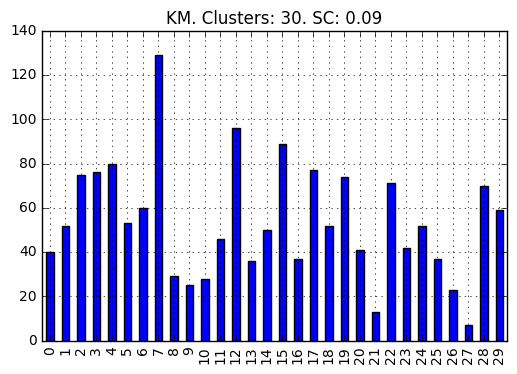

In [11]:
import pandas


cluster_words_num = np.asarray([len(a) for a in cluster_words])
print(cluster_words_num)

df = pandas.DataFrame(data=cluster_words_num,
                      index=range(n_clusters))
df.plot(kind='bar',
        title='KM. Clusters: {0}. SC: {1:.2f}'.format(n_clusters, sc),
        grid=True,
        legend=False)

### Words in clusters

In [12]:
n_top_terms = 5
print("Top %d terms per crisp cluster." % n_top_terms)

Top 5 terms per crisp cluster.


#### Using Cosine Similarity

In [13]:
for i in range(n_clusters):
    print("Cluster %d: %d" % (i, cluster_words[i].shape[0]))
    print("Near")
    for ix in cluster_cos_sim_sort_asc[i][:n_top_terms]:
        print(cluster_cos_sim[i][ix], cluster_words[i][ix])
        
    print()
    print("Far")
    for ix in cluster_cos_sim_sort_des[i][:n_top_terms]:
        print(cluster_cos_sim[i][ix], cluster_words[i][ix])

    print()

Cluster 0: 40
Near
0.051885716835 недоступный
0.0592583322128 нельзя
0.0768916822191 воспользоваться
0.0774545709958 удобно
0.0778138945725 наконец-то

Far
0.263576885623 оплата
0.251885569914 кабинет
0.24904040302 стоить
0.23107802404 оплачивать
0.227540927072 курс

Cluster 1: 52
Near
0.0218380148127 компенсация
0.0250701848057 выделять
0.0359596997495 гривна
0.0420046862185 янукович
0.0429953580574 2012

Far
0.351467459951 отчет
0.294289435505 практика
0.220290513785 снижать
0.208163922315 2014
0.198883026683 декабрь

Cluster 2: 75
Near
0.013749537785 оренбург
0.0225287860738 наличные
0.0274882631416 рефинансирование
0.0293847126183 самара
0.0349583770882 зарплатной

Far
0.26569654143 малый
0.261310793266 взять
0.241939388588 бизнес
0.236638536356 втб
0.233360516978 лицо

Cluster 3: 76
Near
0.0209590519184 замечание
0.0233672089326 http://tco/fpcv4uq4ia
0.033933800961 ситуация
0.0342654895783 постараться
0.0350410101699 логин

Far
0.457142987941 нь
0.266141392501 направлять
0.2187824

#### Using word2vec similarity

In [14]:
for i in range(n_clusters):
    print("Cluster %d: %d" % (i, cluster_words[i].shape[0]))
    print("Similar")
    for word in model.similar_by_vector(km.cluster_centers_[i], topn=n_top_terms):
        print(word[1], word[0])    
    print()

Cluster 0: 40
Similar
0.948114275932312 недоступный
0.9407418370246887 нельзя
0.9303737878799438 подключение
0.9231082797050476 воспользоваться
0.9225454926490784 удобно

Cluster 1: 52
Similar
0.9781620502471924 компенсация
0.9749298095703125 выделять
0.9640402793884277 гривна
0.9579952955245972 янукович
0.957004725933075 2012

Cluster 2: 75
Similar
0.9862505197525024 оренбург
0.9774712324142456 наличные
0.9725118279457092 рефинансирование
0.9706153273582458 самара
0.9650416374206543 зарплатной

Cluster 3: 76
Similar
0.9790409803390503 замечание
0.976632833480835 http://tco/fpcv4uq4ia
0.9660661816596985 ситуация
0.9657345414161682 постараться
0.9649591445922852 логин

Cluster 4: 80
Similar
0.9913057088851929 ес:
0.9873629808425903 союз
0.9843614101409912 евросоюз
0.9835577011108398 корпорация
0.9832949638366699 рсхб

Cluster 5: 53
Similar
0.9834074378013611 кроме
0.9669977426528931 http://
0.9622280597686768 обычный
0.9602132439613342 требовать
0.9504387378692627 площадь

Cluster 6: 60

### Words disposition

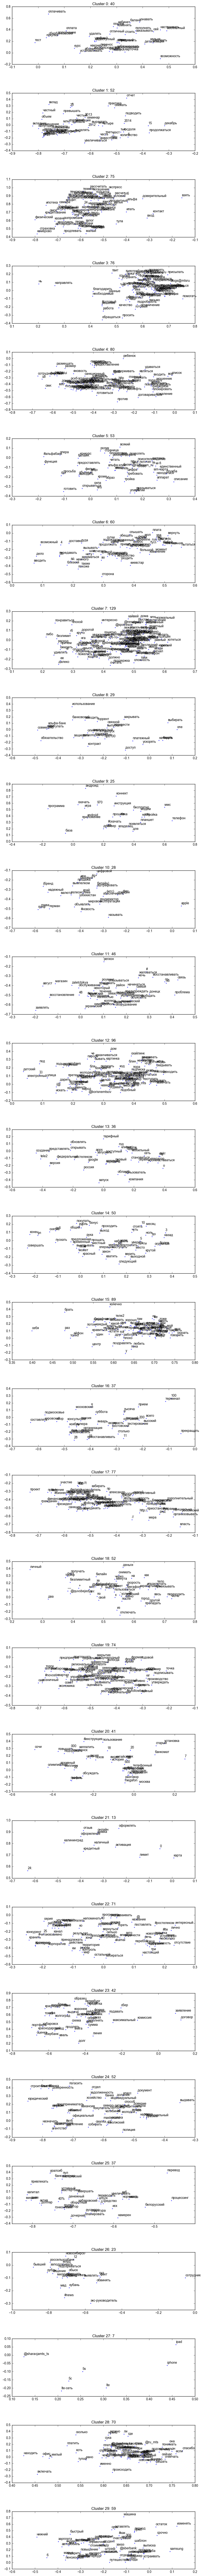

In [15]:
from matplotlib import rc

rc('font', family='Arial')

# centers = pca.fit_transform(km.cluster_centers_)
# centers = km_pca.cluster_centers_

fig, axs = plt.subplots(n_clusters,1, figsize=(10, 140), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for i in range(n_clusters):
    x = cluster_pca_vectors[i][:, 0]
    y = cluster_pca_vectors[i][:, 1]
    
    axs[i].set_title("Cluster %d: %d" % (i, cluster_words[i].shape[0]))
    axs[i].scatter(x, 
                   y,
                   marker='.', s=30, lw=0, alpha=0.7)

    cluster_words_list = cluster_words[i].tolist()

    for ix, label in enumerate(cluster_words_list):
        axs[i].annotate(label,
                        (x[ix], y[ix]),
                        xytext=(0, 3),
                        textcoords = 'offset points', 
                        ha = 'left', 
                        va = 'bottom')
        
#     axs[i].scatter(centers[i, 0],
#                    centers[i, 1],
#                    marker='o', c="white", alpha=1, s=200)

#     axs[i].scatter(centers[i, 0],
#                    centers[i, 1],
#                    marker='$%d$' % i, alpha=1, s=50)